Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2D Point Clouds:
[[20 66]
 [25 58]
 [25 57]
 [60 64]
 [48 44]
 [25 59]
 [65 65]
 [30 42]
 [26 55]
 [49 47]
 [24 61]
 [49 48]
 [62 65]
 [45 42]
 [55 61]
 [38 39]
 [21 65]
 [27 51]
 [29 43]
 [47 43]
 [56 61]
 [42 40]
 [36 40]
 [23 63]
 [57 63]
 [30 43]
 [39 39]
 [59 64]
 [31 41]
 [27 52]
 [27 49]
 [28 46]
 [29 44]
 [51 53]
 [64 65]
 [20 65]
 [28 47]
 [22 64]
 [37 39]
 [15 69]
 [63 65]
 [54 60]
 [41 40]
 [51 51]
 [53 56]
 [47 44]
 [34 40]
 [61 64]
 [18 67]
 [48 46]
 [48 45]
 [24 60]
 [28 48]
 [43 40]
 [23 62]
 [28 45]
 [17 68]
 [50 49]
 [32 40]
 [19 66]
 [51 54]
 [53 58]
 [50 50]
 [27 53]
 [33 40]
 [14 69]
 [32 41]
 [36 39]
 [26 54]
 [40 39]
 [58 63]
 [46 43]
 [16 69]
 [56 62]
 [54 59]
 [44 41]
 [35 40]
 [53 57]
 [52 55]
 [26 56]
 [27 50]
 [51 52]]
(82, 2)


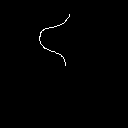

In [39]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import sys
from scipy.interpolate import splprep, splev

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# Read the binary image
binary_image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/binary5.png', cv2.IMREAD_GRAYSCALE)

#binary_image = cv2.bitwise_not(binary_image)
binary_image = cv2.bitwise_not(cv2.transpose(binary_image))

# Find non-zero coordinates (foreground pixels)
non_zero_coords = np.column_stack(np.where(binary_image > 0))

# Display the result or save it as needed
print("2D Point Clouds:")
np.set_printoptions(threshold = 1000)

np.random.shuffle(non_zero_coords)
print(non_zero_coords)
print(non_zero_coords.shape)


# Visualization (optional)
cv2_imshow(binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn.neighbors import KDTree
import pdb
from scipy.linalg import svd


class ClosedCubicBsplineCurve:

    Parameter = (int, float)

    def __init__(self, interval_):
      self.interval_ = interval_
      self.controls_ = np.array([])
      self.positions_ = np.array([])

    def setNewControl(self, controlPs):
        self.clear()
        self.controls_ = controlPs
        rows = []

        for i in range(self.nb_control()):
            for fj in np.arange(0, 1.0 + self.interval_, self.interval_):
                temp = (i, fj)
                p = self.getPos(temp)
                rows.append(p)

        self.positions_ = np.array(rows)

        #pdb.set_trace()

    def getPos(self, para):
        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tf = para[1]
        ki = para[0]
        tm = np.array([[tf**3, tf**2, tf, 1]])

        n = self.nb_control()
        pm = np.zeros((4, 2))
        for i in range(0, 4):
          pm[i, 0] = self.controls_[(ki + i) % n, 0] / 6.0
          pm[i, 1] = self.controls_[(ki + i) % n, 1] / 6.0
        rm = np.dot(np.dot(tm, cm), pm)

        return np.array(rm[0, :])

    def getFirstDiff(self, para):
        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tf = para[1]
        ki = para[0]
        tm = np.array([[3*tf**2, 2*tf, 1, 0]])

        n = self.nb_control()
        pm = np.zeros((4, 2))
        for i in range(0, 4):
          pm[i, 0] = self.controls_[(ki + i) % n, 0] / 6.0
          pm[i, 1] = self.controls_[(ki + i) % n, 1] / 6.0
        rm = np.dot(np.dot(tm, cm), pm)

        return np.array(rm[0, :])

    def getSecondDiff(self, para):
        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tf = para[1]
        ki = para[0]
        tm = np.array([[6*tf, 2, 0, 0]])

        n = self.nb_control()
        pm = np.zeros((4, 2))
        for i in range(0, 4):
          pm[i, 0] = self.controls_[(ki + i) % n, 0] / 6.0
          pm[i, 1] = self.controls_[(ki + i) % n, 1] / 6.0
        rm = np.dot(np.dot(tm, cm), pm)

        return np.array(rm[0, :])

    def getCurvature(self, para):
        fp = self.getFirstDiff(para)
        sp = self.getSecondDiff(para)

        kappa = np.abs(fp[0] * sp[1] - sp[0] * fp[1])
        kappa = kappa / np.sqrt(np.power(fp[0]*fp[0] + fp[1]*fp[1], 3))

        return kappa

    def getTangent(self, para):
        p = self.getFirstDiff(para)
        normalized_p = p / np.linalg.norm(p)

        return normalized_p

    def getNormal(self, para):
        v = self.getTangent(para)
        #pdb.set_trace()

        return np.array([-v[1], v[0]])

    def getCurvCenter(self, para):
        p = self.getPos(para)
        fd = self.getFirstDiff(para)
        sd = self.getSecondDiff(para)

        p1 = (fd[0] * fd[0] + fd[1] * fd[1]) * fd[1]
        p2 = sd[1] * fd[0] - sd[0] * fd[1]
        alpha = p[0] - p1 / p2
        p3 = (fd[0] * fd[0] + fd[1] * fd[1]) * fd[0]
        beta = p[1] + p3 / p2

        return np.array(alpha, beta)

    def findFootPrint(self, givepoints, footPrints):
        footPrints.clear()

        #pdb.set_trace()

        footPrints.extend([(0, 0.0) for _ in range(len(givepoints))])

        iKNei = 1
        iDim = 2
        iNPts = len(self.positions_)
        eps = 0

        dataPts = np.zeros((iNPts, iDim))
        queryPt = np.zeros(iDim)

        for i in range(iNPts):
            dataPts[i, 0] = self.positions_[i][0]
            dataPts[i, 1] = self.positions_[i][1]

        # pdb.set_trace()

        kdTree = KDTree(dataPts)

        squareSum = 0.0
        for i, givepoint in enumerate(givepoints):
            queryPt[0] = givepoint[0]
            queryPt[1] = givepoint[1]
            _, nnIdx = kdTree.query(queryPt.reshape(1, -1), k=iKNei)
            squareSum += kdTree.query(queryPt.reshape(1, -1), k=iKNei)[0][0]
            footPrints[i] = self.getPara(nnIdx[0])

        return squareSum



    def getPara(self, index):
        num = int(self.positions_.shape[0] / self.controls_.shape[0])
        ki = index / num
        tf = self.interval_ * (index - ki * num)

        return int(ki[0]), tf[0]

    def getCoeff(self, para):
        ki = para[0]
        tf = para[1]

        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tv = np.array([[tf**3, tf**2, tf, 1]])
        rv = np.dot(tv, cm)

        newv = np.zeros(self.nb_control())
        for i in range (0,4):
            newv[(ki + i) % self.nb_control()] = rv[0, i] / 6.0

        return newv

    def checkSameSide(self, p1, p2, neip):
        v1 = p2 - neip
        v2 = p1 - neip
        b = True

        if v1[0] * v2[0] + v1[1] * v2[1] < 0:
            b = False

        return b

    def checkInside(self, p):
        strip = 0.02 / self.interval_
        wn = 0

        for i in range(0, int(len(self.positions_)), strip):
            j = (i + strip) / int(len(self.positions_))
            if self.positions_[i][1] <= p[1]:
                if self.positions_[j][1] > p[1]:
                    if self.isLeft(self.positions_[i], self.positions_[j], p) > 0:
                        wn += 1
            else:
                if self.positions_[i][1] <= p[1]:
                    if self.isLeft(self.positions_[i], self.positions_[j], p) < 0:
                        wn -= 1

        if wn == 0:
            return False
        else:
            return True

    def isLeft(self, p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1])

    def getSIntegralSq(self):
        controlNum = self.nb_control()
        pm = np.zeros((2 * controlNum, 2 * controlNum))

        tIntegrated = np.array([[1/3.0, 1/2.0], [1/2.0, 1.0]])
        tm = np.array([[6, 0], [0, 2]])

        cm = np.array([[-1, 3, -3, 1], [3, -6, 3, 0]])
        cm = cm / 6.0

        coffm = np.dot(np.dot(np.dot(np.dot(cm.T, tm.T), tIntegrated), tm), cm)
        for i in range(0, controlNum):
            for j in range(0, 4):
                for n in range(0, 4):
                    kj = (i + j) % controlNum
                    kn = (i + n) % controlNum
                    pm[kj, kn] += coffm[j, n]
                    pm[controlNum + kj, controlNum + kn] += coffm[j, n]

        return pm

    def getFIntegralSq(self):
        controlNum = self.nb_control()
        pm = np.zeros((2 * controlNum, 2 * controlNum))

        tIntergrated = np.array([[1/5.0, 1/4.0, 1/3.0],
                                [1/4.0, 1/3.0, 1/2.0],
                                [1/3.0, 1/2.0, 1/1.0]])

        cm = np.array([[-1, 3, -3, 1],
               [3, -6, 3, 0],
               [-3, 0, 3, 0]], dtype='float64')
        cm /= 6.0

        tm = np.array([[3, 0, 0],
               [0, 2, 0],
               [0, 0, 1]])

        coffm = np.dot(np.dot(np.dot(np.dot(cm.T, tm.T), tIntergrated), tm), cm)
        for i in range(0, controlNum):
            for j in range(0, 4):
                for n in range(0, 4):
                    kj = (i + j) % controlNum
                    kn = (i + n) % controlNum
                    pm[kj, kn] += coffm[j, n]
                    pm[controlNum + kj, controlNum + kn] += coffm[j, n]

        return pm

    def getDistance_sd(self, point, para, ehm, ehv):
        controlNum = self.nb_control()
        ki = para[0]
        tf = para[1]

        kappa = self.getCurvature(para)
        rho = 10e6
        neip = self.getPos(para)
        Tkv = self.getTangent(para)
        Nkv = self.getNormal(para)
        d = np.linalg.norm(point - neip)
        Kv = np.array([0.0, 0.0])
        sign = True

        if kappa != 0.0:
            rho = 1 / kappa
            Kv = self.getCurvCenter(para)
            ddd = np.linalg.norm(Kv - neip)
            sign = self.checkSameSide(Kv, point, neip)

        cm = np.array([[-1, 3, -3, 1],
               [3, -6, 3, 0],
               [-3, 0, 3, 0],
               [1, 4, 1, 0]])
        tv = np.array([tf**3, tf**2, tf, 1])
        rv = np.dot(tv, cm) / 6.0

        am = np.zeros((2, 8))
        am[0, :4] = rv[:4]
        am[1, 4:] = rv[:4]

        #pdb.set_trace()
        leftm = np.zeros((8, 8))
        rightv = np.zeros((8, 1))
        tmpm = np.zeros((8, 8))
        tmpv = np.zeros((8, 1))
        Nkv_col = Nkv[:, np.newaxis]
        Tkv_col = Tkv[:, np.newaxis]
        for iRow in range(8):
          for jCol in range(8):
              leftm[iRow, jCol] = 2 * np.sum(am[:, iRow] * Nkv_col[:, 0] * Nkv_col * am[:, jCol])

        for iRow in range(8):
          rightv[iRow, 0] = 2 * np.sum(am[:, iRow] * Nkv_col[:, 0] * Nkv_col * point)

        if not sign:
            d = -d
            for iRow in range(8):
              for jCol in range(8):
                  tmpm[iRow, jCol] = 2 * np.sum(am[:, iRow] * Tkv_col[:, 0] * Tkv_col * am[:, jCol])

            for iRow in range(8):
              tmpv[iRow, 0] = 2 * np.sum(am[:, iRow] * Tkv_col[:, 0] * Tkv_col * point)

            leftm += d / (d - rho) * tmpm
            rightv += d / (d - rho) * tmpv

        # Write into the entire large matrix
        for iRow in range(8):
            iRowG = self.local2GlobalIdx(ki, iRow)
            for jCol in range(8):
                jColG = self.local2GlobalIdx(ki, jCol)
                ehm[iRowG, jColG] += leftm[iRow, jCol]
            ehv[iRowG] += rightv[iRow, 0]

    def local2GlobalIdx(self, segId, localIdx):
        globalIdx = 0
        if localIdx < 4:
          globalIdx = segId + localIdx
          gloablIdx = globalIdx % self.nb_control()
        else:
          globalIdx = segId + (localIdx - 4)
          globalIdx = globalIdx % self.nb_control()
          globalIdx += self.nb_control()
        return globalIdx

    def nb_control(self):
        #return self.controls_.shape[0]
        return len(self.controls_)

    def clear(self):
        controls_ = np.array([])
        positions_ = np.array([])


In [6]:

class OpenCubicBsplineCurve:

    Parameter = (int, float)

    def __init__(self, interval_):
      self.interval_ = interval_
      self.controls_ = np.array([])
      self.positions_ = np.array([])

    def setNewControl(self, controlPs):
        self.clear()
        self.controls_ = controlPs
        rows = []
        numSeg = self.nb_segment()

        for i in range(numSeg):
            for fj in np.arange(0, 1.0 + self.interval_, self.interval_):
                temp = (i, fj)
                p = self.getPos(temp)
                rows.append(p)

        self.positions_ = np.array(rows)

        #pdb.set_trace()

    def getPos(self, para):
        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tf = para[1]
        ki = para[0]
        tm = np.array([[tf**3, tf**2, tf, 1]])

        n = self.nb_control()
        pm = np.zeros((4, 2))
        for i in range(0, 4):
          pm[i, 0] = self.controls_[(ki + i) % n, 0] / 6.0
          pm[i, 1] = self.controls_[(ki + i) % n, 1] / 6.0
        rm = np.dot(np.dot(tm, cm), pm)

        return np.array(rm[0, :])

    def getFirstDiff(self, para):
        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tf = para[1]
        ki = para[0]
        tm = np.array([[3*tf**2, 2*tf, 1, 0]])

        n = self.nb_control()
        pm = np.zeros((4, 2))
        for i in range(0, 4):
          pm[i, 0] = self.controls_[(ki + i) % n, 0] / 6.0
          pm[i, 1] = self.controls_[(ki + i) % n, 1] / 6.0
        rm = np.dot(np.dot(tm, cm), pm)

        return np.array(rm[0, :])

    def getSecondDiff(self, para):
        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tf = para[1]
        ki = para[0]
        tm = np.array([[6*tf, 2, 0, 0]])

        n = self.nb_control()
        pm = np.zeros((4, 2))
        for i in range(0, 4):
          pm[i, 0] = self.controls_[(ki + i) % n, 0] / 6.0
          pm[i, 1] = self.controls_[(ki + i) % n, 1] / 6.0
        rm = np.dot(np.dot(tm, cm), pm)

        return np.array(rm[0, :])

    def getCurvature(self, para):
        fp = self.getFirstDiff(para)
        sp = self.getSecondDiff(para)

        kappa = np.abs(fp[0] * sp[1] - sp[0] * fp[1])
        kappa = kappa / np.sqrt(np.power(fp[0]*fp[0] + fp[1]*fp[1], 3))

        return kappa

    def getTangent(self, para):
        p = self.getFirstDiff(para)
        normalized_p = p / np.linalg.norm(p)

        return normalized_p

    def getNormal(self, para):
        v = self.getTangent(para)
        #pdb.set_trace()

        return np.array([-v[1], v[0]])

    def getCurvCenter(self, para):
        p = self.getPos(para)
        fd = self.getFirstDiff(para)
        sd = self.getSecondDiff(para)

        p1 = (fd[0] * fd[0] + fd[1] * fd[1]) * fd[1]
        p2 = sd[1] * fd[0] - sd[0] * fd[1]
        alpha = p[0] - p1 / p2
        p3 = (fd[0] * fd[0] + fd[1] * fd[1]) * fd[0]
        beta = p[1] + p3 / p2

        return np.array(alpha, beta)

    def findFootPrint(self, givepoints, footPrints):
        footPrints.clear()

        #pdb.set_trace()

        footPrints.extend([(0, 0.0) for _ in range(len(givepoints))])

        iKNei = 1
        iDim = 2
        iNPts = len(self.positions_)
        eps = 0

        dataPts = np.zeros((iNPts, iDim))
        queryPt = np.zeros(iDim)

        for i in range(iNPts):
            dataPts[i, 0] = self.positions_[i][0]
            dataPts[i, 1] = self.positions_[i][1]

        # pdb.set_trace()

        kdTree = KDTree(dataPts)

        squareSum = 0.0
        for i, givepoint in enumerate(givepoints):
            queryPt[0] = givepoint[0]
            queryPt[1] = givepoint[1]
            _, nnIdx = kdTree.query(queryPt.reshape(1, -1), k=iKNei)
            squareSum += kdTree.query(queryPt.reshape(1, -1), k=iKNei)[0][0]
            footPrints[i] = self.getPara(nnIdx[0])

        return squareSum



    def getPara(self, index):
        num = int(self.positions_.shape[0] / self.nb_segment())
        ki = index / num
        tf = self.interval_ * (index - ki * num)

        return int(ki[0]), tf[0]

    def getCoeff(self, para):
        ki = para[0]
        tf = para[1]

        cm = np.zeros((4, 4))
        cm = np.array([
            [-1, 3, -3, 1],
            [3, -6, 3, 0],
            [-3, 0, 3, 0],
            [1, 4, 1, 0]
        ])

        tv = np.array([[tf**3, tf**2, tf, 1]])
        rv = np.dot(tv, cm)

        newv = np.zeros(self.nb_control())
        for i in range (0,4):
            newv[(ki + i) % self.nb_control()] = rv[0, i] / 6.0

        return newv

    def checkSameSide(self, p1, p2, neip):
        v1 = p2 - neip
        v2 = p1 - neip
        b = True

        if v1[0] * v2[0] + v1[1] * v2[1] < 0:
            b = False

        return b

    def checkInside(self, p):
        strip = 0.02 / self.interval_
        wn = 0

        for i in range(0, int(len(self.positions_)), strip):
            j = (i + strip) / int(len(self.positions_))
            if self.positions_[i][1] <= p[1]:
                if self.positions_[j][1] > p[1]:
                    if self.isLeft(self.positions_[i], self.positions_[j], p) > 0:
                        wn += 1
            else:
                if self.positions_[i][1] <= p[1]:
                    if self.isLeft(self.positions_[i], self.positions_[j], p) < 0:
                        wn -= 1

        if wn == 0:
            return False
        else:
            return True

    def isLeft(self, p1, p2, p3):
        return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p3[0] - p1[0]) * (p2[1] - p1[1])

    def getSIntegralSq(self):
        controlNum = self.nb_control()
        pm = np.zeros((2 * controlNum, 2 * controlNum))

        tIntegrated = np.array([[1/3.0, 1/2.0], [1/2.0, 1.0]])
        tm = np.array([[6, 0], [0, 2]])

        cm = np.array([[-1, 3, -3, 1], [3, -6, 3, 0]])
        cm = cm / 6.0

        coffm = np.dot(np.dot(np.dot(np.dot(cm.T, tm.T), tIntegrated), tm), cm)
        segNum = self.nb_segment()
        for i in range(0, segNum):
            for j in range(0, 4):
                for n in range(0, 4):
                    kj = (i + j)
                    kn = (i + n)
                    pm[kj, kn] += 2 * coffm[j, n]
                    pm[controlNum + kj, controlNum + kn] += 2 * coffm[j, n]

        return pm

    def getFIntegralSq(self):
        controlNum = self.nb_control()
        pm = np.zeros((2 * controlNum, 2 * controlNum))

        tIntergrated = np.array([[1/5.0, 1/4.0, 1/3.0],
                                [1/4.0, 1/3.0, 1/2.0],
                                [1/3.0, 1/2.0, 1/1.0]])

        cm = np.array([[-1, 3, -3, 1],
               [3, -6, 3, 0],
               [-3, 0, 3, 0]], dtype='float64')
        cm /= 6.0

        tm = np.array([[3, 0, 0],
               [0, 2, 0],
               [0, 0, 1]])

        coffm = np.dot(np.dot(np.dot(np.dot(cm.T, tm.T), tIntergrated), tm), cm)
        segNum = self.nb_segment()
        for i in range(0, segNum):
            for j in range(0, 4):
                for n in range(0, 4):
                    kj = (i + j)
                    kn = (i + n)
                    pm[kj, kn] += 2 * coffm[j, n]
                    pm[controlNum + kj, controlNum + kn] += 2 * coffm[j, n]

        return pm

    def getDistance_sd(self, point, para, ehm, ehv):
        ki = para[0]
        tf = para[1]

        kappa = self.getCurvature(para)
        rho = 10e6
        neip = self.getPos(para)
        Tkv = self.getTangent(para)
        Nkv = self.getNormal(para)
        d = np.linalg.norm(point - neip)
        Kv = np.array([0.0, 0.0])
        sign = True

        if kappa != 0.0:
            rho = 1 / kappa
            Kv = self.getCurvCenter(para)
            ddd = np.linalg.norm(Kv - neip)
            sign = self.checkSameSide(Kv, point, neip)

        cm = np.array([[-1, 3, -3, 1],
               [3, -6, 3, 0],
               [-3, 0, 3, 0],
               [1, 4, 1, 0]])
        tv = np.array([tf**3, tf**2, tf, 1])
        rv = np.dot(tv, cm) / 6.0
        am = np.zeros((2, 8))
        am[0, :4] = rv[:4]
        am[1, 4:] = rv[:4]
        leftm = np.zeros((8, 8))
        rightv = np.zeros((8, 1))
        tmpm = np.zeros((8, 8))
        tmpv = np.zeros((8, 1))
        Nkv_col = Nkv[:, np.newaxis]
        Tkv_col = Tkv[:, np.newaxis]
        for iRow in range(8):
          for jCol in range(8):
              leftm[iRow, jCol] = 2 * np.sum(am[:, iRow] * Nkv_col[:, 0] * Nkv_col * am[:, jCol])

        for iRow in range(8):
          rightv[iRow, 0] = 2 * np.sum(am[:, iRow] * Nkv_col[:, 0] * Nkv_col * point)

        if not sign:
          d = -d
          for iRow in range(8):
              for jCol in range(8):
                  tmpm[iRow, jCol] = 2 * np.sum(am[:, iRow] * Tkv_col[:, 0] * Tkv_col * am[:, jCol])

          for iRow in range(8):
              tmpv[iRow, 0] = 2 * np.sum(am[:, iRow] * Tkv_col[:, 0] * Tkv_col * point)
          leftm += d / (d - rho) * tmpm
          rightv += d / (d - rho) * tmpv

        oldp = point - neip
        isOuter = False
        endpoints_thresh = 1e-2

        if ki == 0 and tf <= endpoints_thresh and np.dot(Tkv, oldp) < 0:
            isOuter = True
        if ki == self.nb_segment() - 1 and tf > 1 - endpoints_thresh and np.dot(Tkv, oldp) > 0:
            isOuter = True
        if isOuter:
            leftm_pd = 2 * np.dot(am.transpose(), am)
            rightv_pd = 2 * np.dot(am.transpose(), point)
            cos_theta = np.abs(np.dot(oldp, Tkv) / np.linalg.norm(oldp))
            leftm = cos_theta * leftm_pd + (1 - cos_theta) * leftm
            rightv = cos_theta * rightv_pd + (1 - cos_theta) * rightv

        for iRow in range(8):
              iRowG = self.local2GlobalIdx(ki, iRow)
              for jCol in range(8):
                  jColG = self.local2GlobalIdx(ki, jCol)
                  ehm[iRowG, jColG] += leftm[iRow, jCol]
              ehv[iRowG] += rightv[iRow, 0]

    def local2GlobalIdx(self, segId, localIdx):
        globalIdx = 0
        if localIdx < 4:
          globalIdx = segId + localIdx
        else:
          globalIdx = self.nb_control() + segId + (localIdx - 4)

        return globalIdx

    def getDistance_pd(self, point, para, ehm, ehv):
        ki = para[0]
        tf = para[1]

        cm = np.array([[-1, 3, -3, 1],
               [3, -6, 3, 0],
               [-3, 0, 3, 0],
               [1, 4, 1, 0]])
        tv = np.array([tf**3, tf**2, tf, 1])
        rv = np.dot(tv, cm) / 6.0
        am = np.zeros((2, 8))
        am[0, :4] = rv[:4]
        am[1, 4:] = rv[:4]

        leftm = 2 * np.dot(am.transpose(), am)
        rightv = 2 * np.dot(am.transpose(), point)

        for iRow in range(8):
            iRowG = self.local2GlobalIdx(ki, iRow)
            for jCol in range(8):
                jColG = self.local2GlobalIdx(ki, jCol)
                ehm[iRowG, jColG] += leftm[iRow, jCol]
            ehv[iRowG] += rightv[iRow]


    def nb_control(self):
        #return self.controls_.shape[0]
        return len(self.controls_)

    def nb_segment(self):
        return len(self.controls_) - 3

    def clear(self):
        controls_ = np.array([])
        positions_ = np.array([])

In [7]:
class SplineCurveFitting:

    def initClosedControlPoint(self, points, controlPs, controlNum):
        #controlPs = []

        min_point = np.array(points[0])
        max_point = np.array(points[0])

        for v in points:
            min_point = np.minimum(min_point, v)
            max_point = np.maximum(max_point, v)

        center = min_point + (max_point - min_point) * 0.5
        radius = np.linalg.norm(max_point - min_point) / 2.0

        delta = 2 * np.pi / controlNum

        for i in range(controlNum):
            point = center + np.array([radius * np.cos(i * delta), radius * np.sin(i * delta)])
            #controlPs.append(point)
            controlPs = np.append(controlPs, [point], axis=0)

        return controlPs

    def FitClosedCurve(self, points, curve, controlNum, maxIterNum, alpha, gama, eplison):
        controlNum = (controlNum // 4) * 4

        spline = curve
        controlPs = np.zeros((0, 2))
        controlPs = self.initClosedControlPoint(points, controlPs, controlNum)
        spline.setNewControl(controlPs)

        pm = spline.getSIntegralSq()
        sm = spline.getFIntegralSq()

        parameters = []
        fsd = spline.findFootPrint(points, parameters)
        iterNum = 0

        while fsd > eplison and iterNum < maxIterNum:
          ehm = np.zeros((2 * controlNum, 2 * controlNum))
          ehv = np.zeros(2 * controlNum)

          for i in range(len(parameters)):
            spline.getDistance_sd(points[i], parameters[i], ehm, ehv)

          fm = ehm * 0.5 + pm * alpha + sm * gama
          ehv2 = ehv * 0.5

          resultxy = np.linalg.lstsq(fm, ehv2, rcond=None)[0]
          # u, s, vh = svd(fm)
          # resultxy = np.linalg.solve(np.transpose(u) @ np.diag(s) @ vh, ehv2)
          #pdb.set_trace()

          for i in range(controlNum):
            controlPs[i][0] = resultxy[i]
            controlPs[i][1] = resultxy[i + controlNum]

          #pdb.set_trace()
          spline.setNewControl(controlPs)

          # Increment iterNum if necessary
          iterNum += 1
          fsd = spline.findFootPrint(points, parameters)
          print(iterNum)
          print(fsd)

        return fsd

    def initOpenControlPoint(self, points, controlPs, controlNum):
        #controlPs = []

        gap = len(points) / (controlNum - 2)
        controlPs = np.append(controlPs, [points[0]], axis=0)
        for i in range(controlNum - 2):
            #controlPs.append(points[int(i * gap)])
            controlPs = np.append(controlPs, [points[int(i * gap)]], axis=0)
        controlPs = np.append(controlPs, [points[-1]], axis=0)


        return controlPs

    def FitOpenCurve(self, points, curve, controlNum, maxIterNum, alpha, gama, eplison):
        spline = curve
        controlPs = np.zeros((0, 2))
        controlPs = self.initOpenControlPoint(points, controlPs, controlNum)
        spline.setNewControl(controlPs)

        pm = spline.getSIntegralSq()
        sm = spline.getFIntegralSq()

        parameters = []
        fsd = spline.findFootPrint(points, parameters)
        iterNum = 0

        while fsd > eplison and iterNum < maxIterNum:
          ehm = np.zeros((2 * controlNum, 2 * controlNum))
          ehv = np.zeros(2 * controlNum)

          for i in range(len(parameters)):
            spline.getDistance_sd(points[i], parameters[i], ehm, ehv)

          fm = ehm * 0.5 + pm * alpha + sm * gama
          ehv2 = ehv * 0.5

          resultxy = np.linalg.lstsq(fm, ehv2, rcond=None)[0]
          # u, s, vh = svd(fm)
          # resultxy = np.linalg.solve(np.transpose(u) @ np.diag(s) @ vh, ehv2)
          #pdb.set_trace()

          for i in range(controlNum):
            controlPs[i][0] = resultxy[i]
            controlPs[i][1] = resultxy[i + controlNum]

          #pdb.set_trace()
          spline.setNewControl(controlPs)

          # Increment iterNum if necessary
          iterNum += 1
          print(iterNum)

          fsd = spline.findFootPrint(points, parameters)
          print(fsd)

        return fsd



    def apply(self, points, curve, controlNum = 28, maxIterNum = 30, alpha = 0.002, gama = 0.002, eplison = 0.0001, initType = 1):
         controlNum = (controlNum // 4) * 4

         spline = curve
         controlPs = np.zeros((0, 2))

         #pdb.set_trace()

         controlPs = self.initControlPoint(points, controlPs, controlNum, initType)

         spline.setNewControl(controlPs)

         pm = spline.getSIntegralSq()
         sm = spline.getFIntegralSq()

         parameters = []
         fsd = spline.findFootPrint(points, parameters)
         iterNum = 0

         while fsd > eplison and iterNum < maxIterNum:
            ehm = np.zeros((2 * controlNum, 2 * controlNum))
            ehv = np.zeros(2 * controlNum)

            for i in range(len(parameters)):
                kappa = spline.getCurvature(parameters[i])
                rho = 10e6
                neip = spline.getPos(parameters[i])
                Tkv = spline.getTangent(parameters[i])
                Nkv = spline.getNormal(parameters[i])
                d = np.linalg.norm(points[i] - neip)
                Kv = np.array([0.0, 0.0])
                sign = True
                if kappa != 0.0:
                   rho = 1 / kappa
                   Kv = spline.getCurvCenter(parameters[i])
                   ddd = np.linalg.norm(Kv - neip)
                   sign = spline.checkSameSide(Kv, points[i], neip)

                coffv = spline.getCoeff(parameters[i])
                tempcoffm1 = np.zeros((controlNum, 1))
                for ij in range(controlNum):
                    tempcoffm1[ij, 0] = coffv[ij]
                tempcoffm = np.dot(tempcoffm1, tempcoffm1.T)

                fxx = Tkv[0] * Tkv[0]
                fyy = Tkv[1] * Tkv[1]
                fxy = Tkv[0] * Tkv[1]

                oldp = neip - points[i]

                if not sign:
                   d = -d
                   tempv1 = coffv * (d / (d - rho)) * (fxx * points[i][0] + fxy * points[i][1])
                   tempv2 = coffv * (d / (d - rho)) * (fyy * points[i][1] + fxy * points[i][0])
                   for i2 in range(controlNum):
                       for j in range(controlNum):
                           fp = (d / (d - rho)) * tempcoffm[i2, j]
                           ehm[i2, j] += fxx * fp
                           ehm[i2, j + controlNum] += fxy * fp
                           ehm[i2 + controlNum, j] += fxy * fp
                           ehm[i2 + controlNum, j + controlNum] += fyy * fp

                       ehv[i2] += tempv1[i2]
                       ehv[i2 + controlNum] += tempv2[i2]

                #pdb.set_trace()
                fxx = Nkv[0] * Nkv[0]
                fyy = Nkv[1] * Nkv[1]
                fxy = Nkv[0] * Nkv[1]
                tempv1 = coffv * ([fxx * points[i][0] + fxy * points[i][1]])
                tempv2 = coffv * ([fyy * points[i][1] + fxy * points[i][0]])

                for i2 in range(controlNum):
                    for j in range(controlNum):
                        fp = tempcoffm[i2, j]
                        ehm[i2, j] += fxx * fp
                        ehm[i2, j + controlNum] += fxy * fp
                        ehm[i2 + controlNum, j] += fxy * fp
                        ehm[i2 + controlNum, j + controlNum] += fyy * fp

                    ehv[i2] += tempv1[i2]
                    ehv[i2 + controlNum] += tempv2[i2]

            fm = ehm * 0.5 + pm * alpha + sm * gama
            ehv2 = ehv * 0.5

            resultxy = np.linalg.lstsq(fm, ehv2, rcond=None)[0]
            # u, s, vh = svd(fm)
            # resultxy = np.linalg.solve(np.transpose(u) @ np.diag(s) @ vh, ehv2)
            #pdb.set_trace()

            for i in range(controlNum):
              controlPs[i][0] = resultxy[i]
              controlPs[i][1] = resultxy[i + controlNum]

            #pdb.set_trace()
            spline.setNewControl(controlPs)

            # Increment iterNum if necessary
            iterNum += 1
            print(iterNum)

            fsd = spline.findFootPrint(points, parameters)
            print(fsd)

         return fsd






In [44]:
if __name__ =="__main__":
    curve = OpenCubicBsplineCurve(0.002)
    scf = SplineCurveFitting()

    points = non_zero_coords
    scf.FitOpenCurve(points, curve, 16, 215, 0.005, 0.005, 50)

1
[204.26668198]
2
[86.70466884]
3
[64.14478666]
4
[55.33302184]
5
[62.0288664]
6
[61.84762006]
7
[73.21930479]
8
[128.76927962]
9
[66.84526764]
10
[82.357387]
11
[147.82561887]
12
[138.13092332]
13
[53.7305291]
14
[54.73183215]
15
[283.69049712]
16
[466.55311231]
17
[613.95731199]
18
[202.1247142]
19
[465.12829624]
20
[409.29901013]
21
[301.90982701]
22
[136.35522422]
23
[67.17257799]
24
[62.95547451]
25
[80.2963382]
26
[612.71370907]
27
[301.98542037]
28
[107.67146264]
29
[174.98946017]
30
[151.05413689]
31
[232.60299756]
32
[381.5212199]
33
[471.09506243]
34
[905.51341485]
35
[590.27190047]
36
[985.25427969]
37
[1859.28684134]
38
[1337.94830307]
39
[750.60194656]
40
[173.01398666]
41
[197.84415992]
42
[90.25210389]
43
[290.57345172]
44
[224.21399448]
45
[100.34795078]
46
[101.80719378]
47
[173.48096833]
48
[101.13880687]
49
[240.54944107]
50
[209.23220284]
51
[60.41827554]
52
[134.55197638]
53
[206.69922951]
54
[528.2274118]
55
[573.59363772]
56
[205.89685224]
57
[167.74364819]
58
[

In [38]:
if __name__ =="__main__":
    curve = ClosedCubicBsplineCurve(0.002)
    scf = SplineCurveFitting()

    points = non_zero_coords
    scf.FitClosedCurve(points, curve, 20, 200, 0.005, 0.005, 80)

1
[108.36800423]
2
[88.52134036]
3
[184.97478598]
4
[118.64308452]
5
[84.56815529]
6
[179.50749499]
7
[166.33494528]
8
[143.85732559]
9
[136.43410132]
10
[123.32427739]
11
[242.71394931]
12
[252.10622044]
13
[237.32888503]
14
[412.40538215]
15
[328.02548888]
16
[273.38704467]
17
[370.11765495]
18
[355.30730151]
19
[379.8836661]
20
[481.90082988]
21
[416.14865663]
22
[395.50444567]
23
[433.61553498]
24
[446.91839543]
25
[405.58758773]
26
[317.66303214]
27
[279.31422881]
28
[337.43001779]
29
[334.72113537]
30
[346.4162943]
31
[344.01759464]
32
[215.21195349]
33
[177.98748103]
34
[279.53221353]
35
[405.6165602]
36
[227.13317423]
37
[277.8337693]
38
[247.86184004]
39
[167.64640236]
40
[153.20739691]
41
[316.22010621]
42
[582.67178782]
43
[499.39985866]
44
[451.51388283]
45
[302.65098386]
46
[261.91720801]
47
[230.52908572]
48
[198.22612379]
49
[195.21797442]
50
[152.9322515]
51
[222.86442412]
52
[216.7851981]
53
[298.65694378]
54
[188.00104902]
55
[293.6247638]
56
[327.08714214]
57
[463.99

In [45]:
print(curve.controls_)

[[69.4829076  62.62936834]
 [66.92070527 63.86622837]
 [64.40180836 64.84486579]
 [59.12659634 67.4788184 ]
 [50.54946031 47.17995355]
 [45.31226193 41.22392009]
 [33.39573809 38.04268078]
 [27.16752098 46.74427246]
 [26.59554104 54.49017094]
 [24.77358121 58.96402298]
 [21.90593055 64.29644959]
 [18.47014344 66.69508272]
 [15.19780529 69.51603691]
 [13.86610841 68.99174779]
 [13.22387377 68.78127335]
 [12.5760937  68.53269043]]


In [46]:
print(curve.positions_)

[[66.92792284 63.82319127]
 [66.92284183 63.82540625]
 [66.91776096 63.82762022]
 ...
 [13.22552952 68.77583975]
 [13.22423953 68.77538092]
 [13.22294953 68.77492194]]


<ipython-input-47-3bafcc4f7bc9>:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(non_zero_coords[:, 0], non_zero_coords[:, 1], s=10, c=(0.8, 0.8, 0.8), marker='o')
<ipython-input-47-3bafcc4f7bc9>:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-b*" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(curve.controls_[:,0],curve.controls_[:,1],'-b*',linestyle='--', dashes=(5, 5))


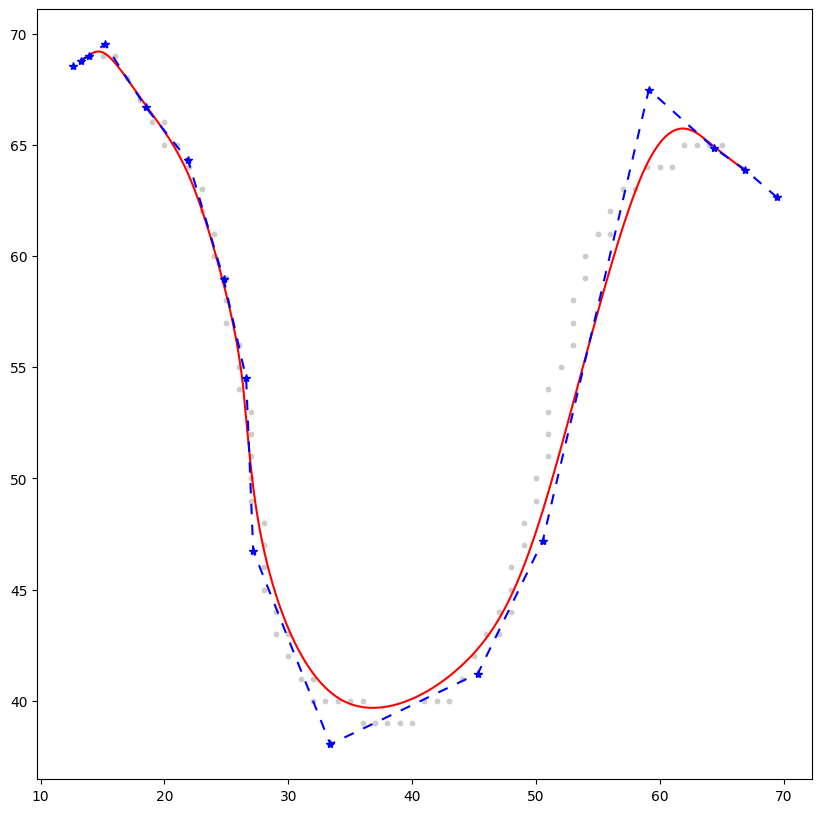

In [47]:
xx = non_zero_coords[:, 0]
yy = non_zero_coords[:, 1]
fig = plt.figure(figsize=(10,10))


# plt.scatter(non_zero_coords[:, 0], non_zero_coords[:, 1], s=10, c=(0.8, 0.8, 0.8), marker='o')
# plt.grid(True)

ax = fig.add_subplot(111)
ax.scatter(non_zero_coords[:, 0], non_zero_coords[:, 1], s=10, c=(0.8, 0.8, 0.8), marker='o')
ax.plot(curve.positions_[:,0],curve.positions_[:,1],'-r')
ax.plot(curve.controls_[:,0],curve.controls_[:,1],'-b*',linestyle='--', dashes=(5, 5))